In [1]:
import scanpy as sc
import numpy as np
import torch
import pandas as pd
from model import ZINBVAE
from dataset import base_genes
from training import train
from utils import sample_zinb, plot_column_densities, set_seed, plot_umap_pca

In [2]:
n_cells=10000
n_genes=20
target_zero_prob=.8
n_epochs = 1000

In [3]:
x, mu_values, theta_values, pi_values = base_genes(n_cells=n_cells, 
                                                    n_genes=n_genes, 
                                                    target_zero_prob=target_zero_prob, 
                                                    mu_bot=1.0, 
                                                    mu_top=10, 
                                                    theta_bot=0.5, 
                                                    theta_top=2.0,
                                                    seed=42)

Actual overall zero proportion: 0.7997


/mnt/data2/home/leonardo/miniconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


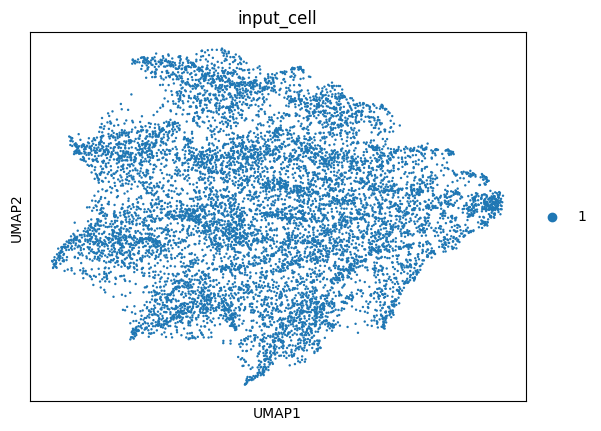

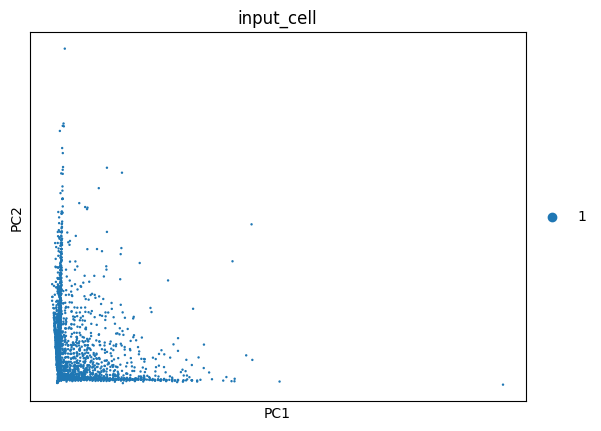

In [ ]:
adata = sc.AnnData(x)
adata.obs["input_cell"] = pd.Categorical(["1"] * adata.n_obs)

plot_umap_pca(adata, color="input_cell", random_state=0)

In [5]:
#x[:n_cells//2,:] +=10

In [6]:
n_epochs = 1000
set_seed(11)
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = ZINBVAE(input_dim=x.shape[1], hidden_dim=40, latent_dim=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

mean, disp, pi, mu, logvar, z = train(vae, optimizer, x, n_epochs, n_cells, mu_values, 
                                      theta_values, pi_values, seed=11, device=device)


to_numpy = lambda x: x.detach().cpu().numpy() if hasattr(x, 'detach') else np.array(x)
mean, disp, pi, mu, logvar, z = list(map(to_numpy, [mean, disp, pi, mu, logvar, z]))

Epoch 0, Loss: 10.0115, Mean MSE: 32.2377, Theta MSE: 1.3872, Pi MSE: 0.0610
Epoch 1, Loss: 9.5001, Mean MSE: 32.1634, Theta MSE: 1.3920, Pi MSE: 0.0625
Epoch 2, Loss: 9.0388, Mean MSE: 32.1073, Theta MSE: 1.3965, Pi MSE: 0.0639
Epoch 3, Loss: 8.5646, Mean MSE: 32.0173, Theta MSE: 1.4004, Pi MSE: 0.0656
Epoch 4, Loss: 8.0904, Mean MSE: 31.9461, Theta MSE: 1.4038, Pi MSE: 0.0673
Epoch 5, Loss: 7.8169, Mean MSE: 31.8741, Theta MSE: 1.4097, Pi MSE: 0.0691
Epoch 6, Loss: 7.5000, Mean MSE: 31.7781, Theta MSE: 1.4121, Pi MSE: 0.0711
Epoch 7, Loss: 7.1872, Mean MSE: 31.6908, Theta MSE: 1.4136, Pi MSE: 0.0728
Epoch 8, Loss: 6.9489, Mean MSE: 31.6233, Theta MSE: 1.4173, Pi MSE: 0.0748
Epoch 9, Loss: 6.6115, Mean MSE: 31.5438, Theta MSE: 1.4194, Pi MSE: 0.0766
Epoch 10, Loss: 6.3676, Mean MSE: 31.4535, Theta MSE: 1.4186, Pi MSE: 0.0786
Epoch 11, Loss: 6.2607, Mean MSE: 31.3640, Theta MSE: 1.4195, Pi MSE: 0.0809
Epoch 12, Loss: 5.9608, Mean MSE: 31.3045, Theta MSE: 1.4206, Pi MSE: 0.0827
Epoch 13

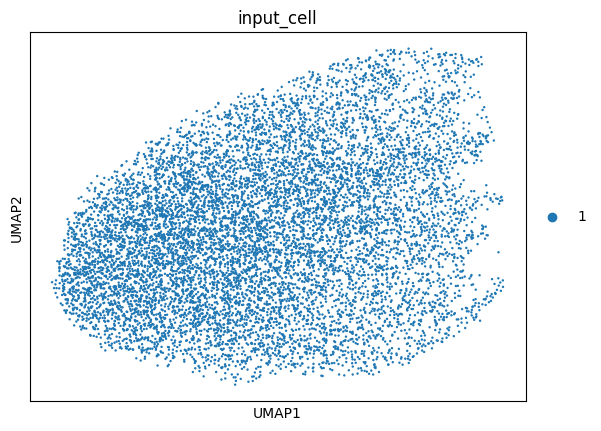

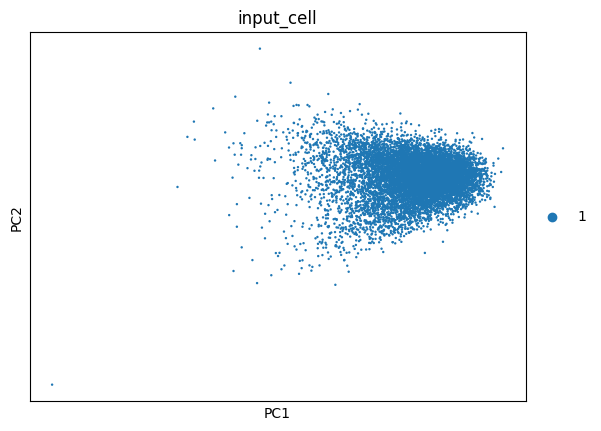

In [7]:
adata_z = sc.AnnData(X=z)
adata_z.obs["input_cell"] = adata.obs["input_cell"].copy()

plot_umap_pca(adata_z, color="input_cell", random_state=0)

In [8]:
zinb_sample = sample_zinb(mean, disp, pi, eps=1e-8, seed=11)

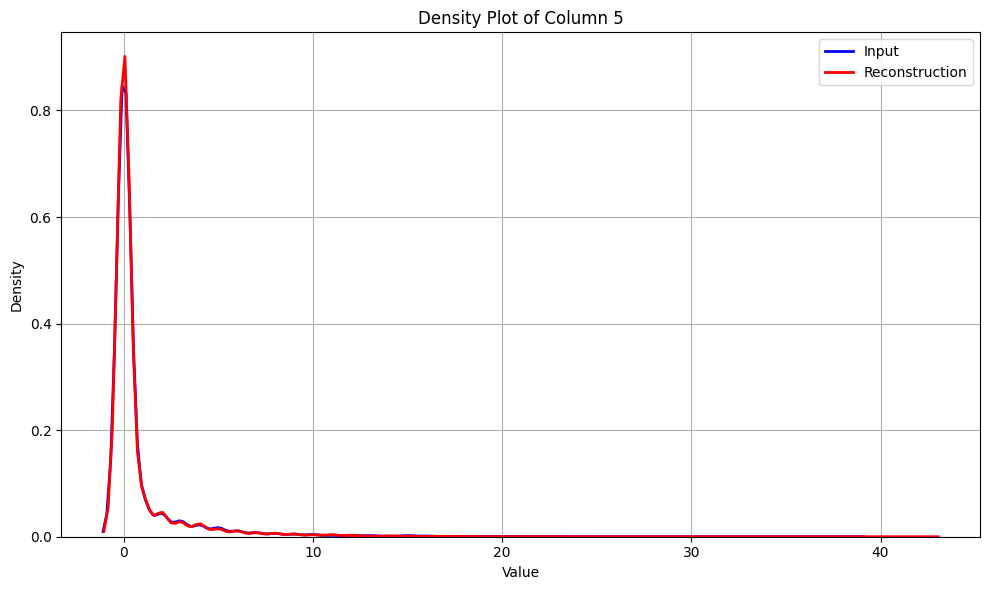

In [9]:
plot_column_densities(matrix1=x, matrix2=zinb_sample, column_index=5, label1='Input', label2='Reconstruction')

In [10]:
# Step 1: Create AnnData for the new observations
new_adata = sc.AnnData(X=zinb_sample)
new_adata.var_names = adata.var_names  # Ensure variable names match
new_adata.obs_names = [f"new_obs_{i}" for i in range(new_adata.n_obs)]

# Step 2: Assign "1" to base_gene for new observations
new_adata.obs["input_cell"] = pd.Categorical(["0"] * new_adata.n_obs)

# Step 4: Concatenate and overwrite
adata = sc.concat([adata, new_adata], axis=0)

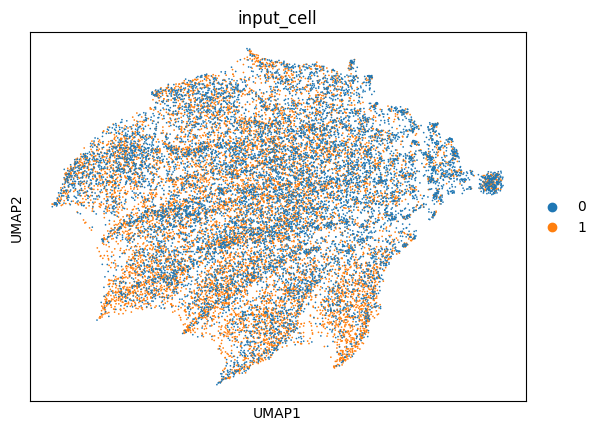

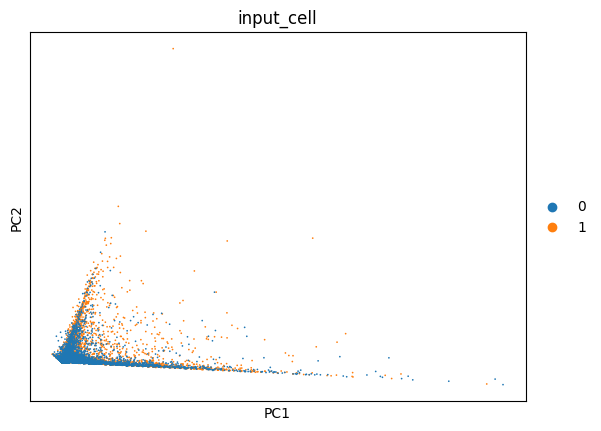

In [11]:
plot_umap_pca(adata, color="input_cell", random_state=0)